In [1]:
import os
import json
import pytz
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
df_weekly = pd.read_excel("Sample_weekly_data.xlsx")

print(df_weekly.shape)

df_weekly.head()

(51, 12)


,Unnamed: 0,Week Start,Week End,Item Id,Inventory,Product Type,GMV,Page Views,EBC Page Views,Units Sold,Ad Spend,Ad Sales
0,0,2025-02-24,2025-03-02,1689427573,1436,Bed Sheets,209.70,746,144,6,377.85,921.70
1,1,2025-02-17,2025-02-23,1689427573,3016,Bed Sheets,915.69,1041,63,26,335.26,714.78
2,2,2025-02-10,2025-02-16,1689427573,2090,Bed Sheets,643.08,1225,152,18,361.42,1199.30
3,3,2025-02-03,2025-02-09,1689427573,1617,Bed Sheets,-34.95,1490,156,-1,374.73,949.44
4,4,2025-01-27,2025-02-02,1689427573,2694,Bed Sheets,258.63,2025,825,7,378.42,1027.57


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming df_weekly is your original dataframe
data = df_weekly.copy()

# Preprocessing
data["Units Sold"] = data["Units Sold"].apply(lambda x: max(x, 0))
data["GMV"] = data["GMV"].apply(lambda x: max(x, 0))

# Prepare data for Prophet
df = data[[
    "Week Start", "Units Sold", "Inventory", "GMV", 
    "Page Views", "EBC Page Views", "Ad Spend", "Ad Sales"
]]
df = df.rename(columns={"Week Start": "ds", "Units Sold": "y"})

# Create train-test split (80-20)
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Initialize and train Prophet model
model = Prophet()

# Add regressors
regressors = ["Inventory", "GMV", "Page Views", "EBC Page Views", "Ad Spend", "Ad Sales"]
for regressor in regressors:
    model.add_regressor(regressor)

# Fit the model on training data
model.fit(train_df)

# Create future dataframe for the test period
future = model.make_future_dataframe(periods=len(test_df), freq="W")

# Add regressor values for the entire period
for regressor in regressors:
    future[regressor] = pd.concat([train_df[regressor], test_df[regressor]]).reset_index(drop=True)

# Make predictions
forecast = model.predict(future)

# Extract predictions for test period
test_predictions = forecast.tail(len(test_df))

# Calculate metrics
mae = mean_absolute_error(test_df['y'], test_predictions['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['y'], test_predictions['yhat']))
r2 = r2_score(test_df['y'], test_predictions['yhat'])

print(f"Model Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Square Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Date': test_df['ds'],
    'Actual': test_df['y'],
    'Predicted': test_predictions['yhat'],
    'Lower Bound': test_predictions['yhat_lower'],
    'Upper Bound': test_predictions['yhat_upper']
})

print("\nPrediction Comparison:")
comparison_df

21:36:06 - cmdstanpy - INFO - Chain [1] start processing
21:36:06 - cmdstanpy - INFO - Chain [1] done processing


Model Performance Metrics:
Mean Absolute Error: 2.78
Root Mean Square Error: 3.05
R-squared Score: 0.91

Prediction Comparison:


,Date,Actual,Predicted,Lower Bound,Upper Bound
40,2024-05-20,7,6.974698,4.997915,8.952063
41,2024-05-13,13,14.741000,12.734653,16.856827
42,2024-05-06,15,17.257229,15.237603,19.192630
43,2024-04-29,21,22.859960,20.799853,24.943146
44,2024-04-22,45,40.121120,38.004128,42.169335
45,2024-04-15,34,37.780297,35.660802,39.757511
46,2024-04-08,29,32.548984,30.578859,34.601815
47,2024-04-01,32,35.449848,33.346245,37.303319
48,2024-03-25,17,19.346259,17.363572,21.361109
49,2024-03-18,21,23.899060,21.853339,25.797972


In [48]:
# Calculate feature importance correctly
coefficients = model.params['beta'].flatten()  # Flatten the array
feature_importance = pd.DataFrame({
    'Feature': regressors,
    'Coefficient': coefficients
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance:")
feature_importance


Feature Importance:


,Feature,Coefficient,Abs_Coefficient
1,GMV,0.228379,0.228379
4,Ad Spend,0.031302,0.031302
5,Ad Sales,-0.020787,0.020787
3,EBC Page Views,0.007932,0.007932
2,Page Views,0.001106,0.001106
0,Inventory,-0.000712,0.000712


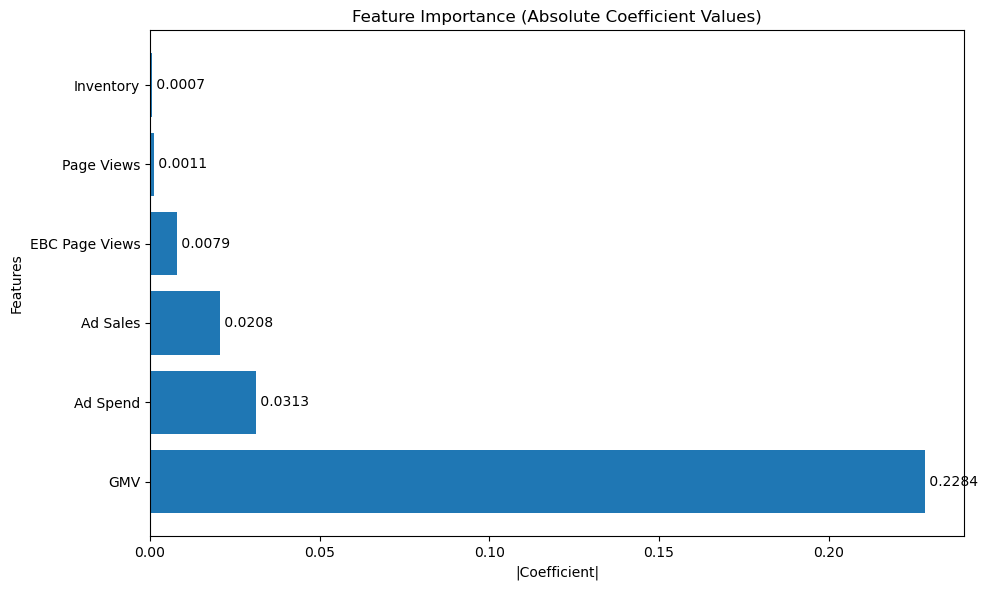

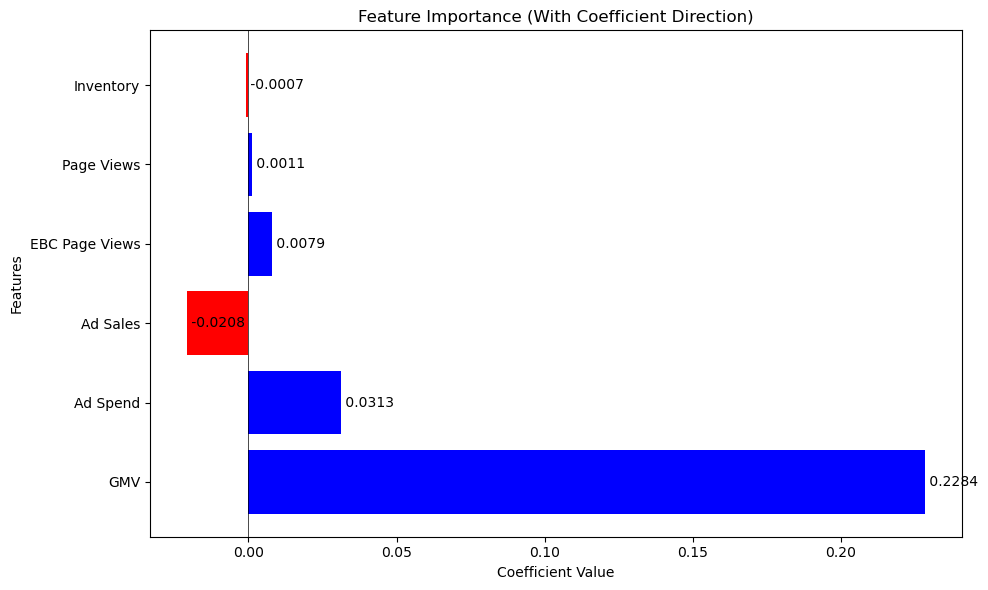

In [49]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'])
plt.title('Feature Importance (Absolute Coefficient Values)')
plt.xlabel('|Coefficient|')
plt.ylabel('Features')

# Add value labels on the bars
for i, v in enumerate(feature_importance['Abs_Coefficient']):
    plt.text(v, i, f' {v:.4f}', va='center')

plt.tight_layout()
plt.show()

# Optional: Create a second visualization showing both positive and negative coefficients
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
plt.title('Feature Importance (With Coefficient Direction)')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')

# Add value labels on the bars
for i, v in enumerate(feature_importance['Coefficient']):
    plt.text(v, i, f' {v:.4f}', va='center')

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [50]:
# Calculate prediction intervals coverage
in_interval = ((test_df['y'] >= test_predictions['yhat_lower']) & 
              (test_df['y'] <= test_predictions['yhat_upper']))
coverage = in_interval.mean()
print(f"\nPrediction Interval Coverage: {coverage:.2%}")


Prediction Interval Coverage: 45.45%


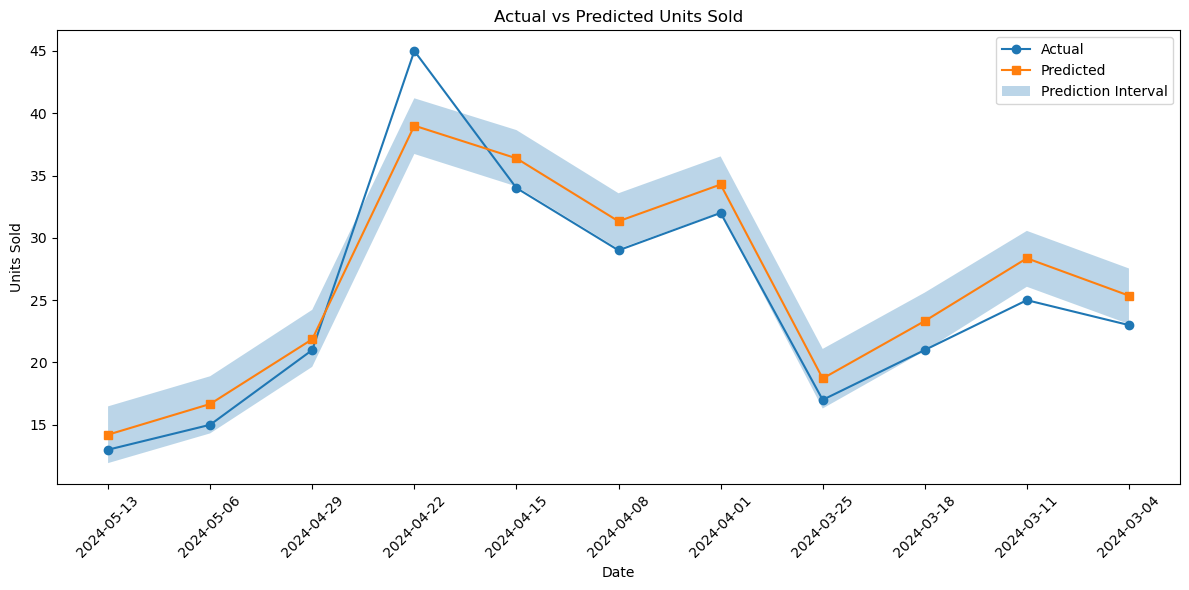

In [ ]:
# Optional: Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual', marker='o')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted', marker='s')
plt.fill_between(comparison_df['Date'],
                comparison_df['Lower Bound'],
                comparison_df['Upper Bound'],
                alpha=0.3, label='Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

23:54:38 - cmdstanpy - INFO - Chain [1] start processing


Testing 384 combinations of parameters


23:54:38 - cmdstanpy - INFO - Chain [1] done processing
23:54:38 - cmdstanpy - INFO - Chain [1] start processing


MAE: 11.89, RMSE: 14.28, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:54:39 - cmdstanpy - INFO - Chain [1] done processing
23:54:39 - cmdstanpy - INFO - Chain [1] start processing


MAE: 11.82, RMSE: 14.22, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:54:39 - cmdstanpy - INFO - Chain [1] done processing
23:54:39 - cmdstanpy - INFO - Chain [1] start processing


MAE: 12.95, RMSE: 15.21, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:54:41 - cmdstanpy - INFO - Chain [1] done processing
23:54:41 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.34, RMSE: 17.04, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:54:41 - cmdstanpy - INFO - Chain [1] done processing
23:54:42 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.61, RMSE: 17.28, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:54:42 - cmdstanpy - INFO - Chain [1] done processing
23:54:42 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.63, RMSE: 17.30, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:54:42 - cmdstanpy - INFO - Chain [1] done processing
23:54:43 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.58, RMSE: 2.84, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:54:43 - cmdstanpy - INFO - Chain [1] done processing
23:54:43 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.64, RMSE: 2.88, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:54:43 - cmdstanpy - INFO - Chain [1] done processing
23:54:43 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.65, RMSE: 2.89, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:54:44 - cmdstanpy - INFO - Chain [1] done processing
23:54:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.32, RMSE: 5.67, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:54:44 - cmdstanpy - INFO - Chain [1] done processing
23:54:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.31, RMSE: 5.66, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:54:44 - cmdstanpy - INFO - Chain [1] done processing
23:54:45 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.31, RMSE: 5.66, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:54:45 - cmdstanpy - INFO - Chain [1] done processing
23:54:45 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:54:45 - cmdstanpy - INFO - Chain [1] done processing
23:54:45 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:54:45 - cmdstanpy - INFO - Chain [1] done processing
23:54:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:54:46 - cmdstanpy - INFO - Chain [1] done processing
23:54:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:54:46 - cmdstanpy - INFO - Chain [1] done processing
23:54:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:54:46 - cmdstanpy - INFO - Chain [1] done processing
23:54:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:54:47 - cmdstanpy - INFO - Chain [1] done processing
23:54:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.20, RMSE: 2.60, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:54:47 - cmdstanpy - INFO - Chain [1] done processing
23:54:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.24, RMSE: 2.62, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:54:48 - cmdstanpy - INFO - Chain [1] done processing
23:54:48 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.22, RMSE: 2.61, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:54:48 - cmdstanpy - INFO - Chain [1] done processing
23:54:48 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.23, RMSE: 4.44, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:54:49 - cmdstanpy - INFO - Chain [1] done processing
23:54:49 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.21, RMSE: 4.42, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:54:49 - cmdstanpy - INFO - Chain [1] done processing
23:54:49 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.21, RMSE: 4.42, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:54:50 - cmdstanpy - INFO - Chain [1] done processing
23:54:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 11.89, RMSE: 14.28, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:54:50 - cmdstanpy - INFO - Chain [1] done processing
23:54:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 11.82, RMSE: 14.22, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:54:50 - cmdstanpy - INFO - Chain [1] done processing
23:54:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 12.95, RMSE: 15.21, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:54:52 - cmdstanpy - INFO - Chain [1] done processing
23:54:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.34, RMSE: 17.04, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:54:53 - cmdstanpy - INFO - Chain [1] done processing
23:54:53 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.61, RMSE: 17.28, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:54:53 - cmdstanpy - INFO - Chain [1] done processing
23:54:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.63, RMSE: 17.30, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:54:54 - cmdstanpy - INFO - Chain [1] done processing
23:54:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.58, RMSE: 2.84, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:54:54 - cmdstanpy - INFO - Chain [1] done processing
23:54:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.64, RMSE: 2.88, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:54:54 - cmdstanpy - INFO - Chain [1] done processing
23:54:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.65, RMSE: 2.89, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:54:55 - cmdstanpy - INFO - Chain [1] done processing
23:54:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.32, RMSE: 5.67, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:54:55 - cmdstanpy - INFO - Chain [1] done processing
23:54:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.31, RMSE: 5.66, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:54:56 - cmdstanpy - INFO - Chain [1] done processing
23:54:56 - cmdstanpy - INFO - Chain [1] start processing
23:54:56 - cmdstanpy - INFO - Chain [1] done processing


MAE: 5.31, RMSE: 5.66, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:54:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:54:56 - cmdstanpy - INFO - Chain [1] done processing
23:54:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:54:57 - cmdstanpy - INFO - Chain [1] done processing
23:54:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:54:57 - cmdstanpy - INFO - Chain [1] done processing
23:54:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:54:57 - cmdstanpy - INFO - Chain [1] done processing
23:54:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:54:58 - cmdstanpy - INFO - Chain [1] done processing
23:54:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:54:58 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.20, RMSE: 2.60, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:54:58 - cmdstanpy - INFO - Chain [1] start processing
23:54:59 - cmdstanpy - INFO - Chain [1] done processing


MAE: 2.24, RMSE: 2.62, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:54:59 - cmdstanpy - INFO - Chain [1] start processing
23:55:00 - cmdstanpy - INFO - Chain [1] done processing
23:55:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.22, RMSE: 2.61, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:00 - cmdstanpy - INFO - Chain [1] done processing
23:55:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.23, RMSE: 4.44, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:01 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4.21, RMSE: 4.42, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:01 - cmdstanpy - INFO - Chain [1] start processing
23:55:01 - cmdstanpy - INFO - Chain [1] done processing
23:55:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.21, RMSE: 4.42, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:02 - cmdstanpy - INFO - Chain [1] done processing
23:55:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 11.89, RMSE: 14.28, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:02 - cmdstanpy - INFO - Chain [1] done processing
23:55:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 11.82, RMSE: 14.22, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:03 - cmdstanpy - INFO - Chain [1] done processing
23:55:03 - cmdstanpy - INFO - Chain [1] start processing


MAE: 12.95, RMSE: 15.21, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:05 - cmdstanpy - INFO - Chain [1] done processing
23:55:05 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.34, RMSE: 17.04, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:05 - cmdstanpy - INFO - Chain [1] done processing
23:55:05 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.61, RMSE: 17.28, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:06 - cmdstanpy - INFO - Chain [1] done processing
23:55:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.63, RMSE: 17.30, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:06 - cmdstanpy - INFO - Chain [1] done processing
23:55:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.58, RMSE: 2.84, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:06 - cmdstanpy - INFO - Chain [1] done processing
23:55:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.64, RMSE: 2.88, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:07 - cmdstanpy - INFO - Chain [1] done processing
23:55:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.65, RMSE: 2.89, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:07 - cmdstanpy - INFO - Chain [1] done processing
23:55:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.32, RMSE: 5.67, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:08 - cmdstanpy - INFO - Chain [1] done processing
23:55:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.31, RMSE: 5.66, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:08 - cmdstanpy - INFO - Chain [1] done processing
23:55:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.31, RMSE: 5.66, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:08 - cmdstanpy - INFO - Chain [1] done processing
23:55:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:09 - cmdstanpy - INFO - Chain [1] done processing
23:55:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:09 - cmdstanpy - INFO - Chain [1] done processing
23:55:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:09 - cmdstanpy - INFO - Chain [1] done processing
23:55:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:10 - cmdstanpy - INFO - Chain [1] done processing
23:55:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:10 - cmdstanpy - INFO - Chain [1] done processing
23:55:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:11 - cmdstanpy - INFO - Chain [1] done processing
23:55:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.20, RMSE: 2.60, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:11 - cmdstanpy - INFO - Chain [1] done processing
23:55:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.24, RMSE: 2.62, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:11 - cmdstanpy - INFO - Chain [1] done processing
23:55:12 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.22, RMSE: 2.61, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:12 - cmdstanpy - INFO - Chain [1] done processing
23:55:12 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.23, RMSE: 4.44, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:12 - cmdstanpy - INFO - Chain [1] done processing
23:55:12 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.21, RMSE: 4.42, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:13 - cmdstanpy - INFO - Chain [1] done processing
23:55:13 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.21, RMSE: 4.42, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:13 - cmdstanpy - INFO - Chain [1] done processing
23:55:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 11.89, RMSE: 14.28, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:14 - cmdstanpy - INFO - Chain [1] done processing
23:55:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 11.82, RMSE: 14.22, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:14 - cmdstanpy - INFO - Chain [1] done processing
23:55:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 12.95, RMSE: 15.21, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:16 - cmdstanpy - INFO - Chain [1] done processing
23:55:16 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.34, RMSE: 17.04, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:17 - cmdstanpy - INFO - Chain [1] done processing
23:55:17 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.61, RMSE: 17.28, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:17 - cmdstanpy - INFO - Chain [1] done processing
23:55:17 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.63, RMSE: 17.30, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:18 - cmdstanpy - INFO - Chain [1] done processing
23:55:18 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.58, RMSE: 2.84, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:18 - cmdstanpy - INFO - Chain [1] done processing
23:55:18 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.64, RMSE: 2.88, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:18 - cmdstanpy - INFO - Chain [1] done processing
23:55:18 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.65, RMSE: 2.89, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:19 - cmdstanpy - INFO - Chain [1] done processing
23:55:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.32, RMSE: 5.67, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:19 - cmdstanpy - INFO - Chain [1] done processing
23:55:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.31, RMSE: 5.66, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:19 - cmdstanpy - INFO - Chain [1] done processing
23:55:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.31, RMSE: 5.66, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:20 - cmdstanpy - INFO - Chain [1] done processing
23:55:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:20 - cmdstanpy - INFO - Chain [1] done processing
23:55:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:21 - cmdstanpy - INFO - Chain [1] done processing
23:55:21 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.48, RMSE: 2.78, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:21 - cmdstanpy - INFO - Chain [1] done processing
23:55:21 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:21 - cmdstanpy - INFO - Chain [1] done processing
23:55:21 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:22 - cmdstanpy - INFO - Chain [1] done processing
23:55:22 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:22 - cmdstanpy - INFO - Chain [1] done processing
23:55:22 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.20, RMSE: 2.60, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:22 - cmdstanpy - INFO - Chain [1] done processing
23:55:22 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.24, RMSE: 2.62, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:23 - cmdstanpy - INFO - Chain [1] done processing
23:55:23 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.22, RMSE: 2.61, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:23 - cmdstanpy - INFO - Chain [1] done processing
23:55:23 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.23, RMSE: 4.44, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:24 - cmdstanpy - INFO - Chain [1] done processing
23:55:24 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.21, RMSE: 4.42, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:24 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4.21, RMSE: 4.42, Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:25 - cmdstanpy - INFO - Chain [1] start processing
23:55:25 - cmdstanpy - INFO - Chain [1] done processing
23:55:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.17, RMSE: 15.43, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:25 - cmdstanpy - INFO - Chain [1] done processing
23:55:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.30, RMSE: 15.53, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:26 - cmdstanpy - INFO - Chain [1] done processing
23:55:26 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.27, RMSE: 15.53, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:26 - cmdstanpy - INFO - Chain [1] done processing
23:55:26 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.00, RMSE: 17.62, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:26 - cmdstanpy - INFO - Chain [1] done processing
23:55:27 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.75, RMSE: 18.27, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:27 - cmdstanpy - INFO - Chain [1] done processing
23:55:27 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.57, RMSE: 18.12, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:27 - cmdstanpy - INFO - Chain [1] done processing
23:55:27 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.55, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:27 - cmdstanpy - INFO - Chain [1] done processing
23:55:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.57, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:28 - cmdstanpy - INFO - Chain [1] done processing
23:55:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.56, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:28 - cmdstanpy - INFO - Chain [1] done processing
23:55:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.18, RMSE: 5.49, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:29 - cmdstanpy - INFO - Chain [1] done processing
23:55:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.18, RMSE: 5.49, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:29 - cmdstanpy - INFO - Chain [1] done processing
23:55:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.17, RMSE: 5.48, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:29 - cmdstanpy - INFO - Chain [1] done processing
23:55:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:30 - cmdstanpy - INFO - Chain [1] done processing
23:55:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:30 - cmdstanpy - INFO - Chain [1] done processing
23:55:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:30 - cmdstanpy - INFO - Chain [1] done processing
23:55:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:31 - cmdstanpy - INFO - Chain [1] done processing
23:55:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.20, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:31 - cmdstanpy - INFO - Chain [1] done processing
23:55:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.20, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:31 - cmdstanpy - INFO - Chain [1] done processing
23:55:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.38, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:32 - cmdstanpy - INFO - Chain [1] done processing
23:55:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.39, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:32 - cmdstanpy - INFO - Chain [1] done processing
23:55:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.38, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:32 - cmdstanpy - INFO - Chain [1] done processing
23:55:33 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.18, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:33 - cmdstanpy - INFO - Chain [1] done processing
23:55:33 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.17, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:33 - cmdstanpy - INFO - Chain [1] done processing
23:55:33 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.17, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:33 - cmdstanpy - INFO - Chain [1] done processing
23:55:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.17, RMSE: 15.43, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:34 - cmdstanpy - INFO - Chain [1] done processing
23:55:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.30, RMSE: 15.53, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:34 - cmdstanpy - INFO - Chain [1] done processing
23:55:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.27, RMSE: 15.53, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:35 - cmdstanpy - INFO - Chain [1] done processing
23:55:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.00, RMSE: 17.62, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:35 - cmdstanpy - INFO - Chain [1] done processing
23:55:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.75, RMSE: 18.27, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:35 - cmdstanpy - INFO - Chain [1] done processing
23:55:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.57, RMSE: 18.12, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:36 - cmdstanpy - INFO - Chain [1] done processing
23:55:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.55, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:36 - cmdstanpy - INFO - Chain [1] done processing
23:55:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.57, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:37 - cmdstanpy - INFO - Chain [1] done processing
23:55:37 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.56, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:37 - cmdstanpy - INFO - Chain [1] done processing
23:55:37 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.18, RMSE: 5.49, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:37 - cmdstanpy - INFO - Chain [1] done processing
23:55:37 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.18, RMSE: 5.49, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:38 - cmdstanpy - INFO - Chain [1] done processing
23:55:38 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.17, RMSE: 5.48, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:38 - cmdstanpy - INFO - Chain [1] done processing
23:55:38 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:39 - cmdstanpy - INFO - Chain [1] done processing
23:55:39 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:39 - cmdstanpy - INFO - Chain [1] done processing
23:55:39 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:39 - cmdstanpy - INFO - Chain [1] done processing
23:55:39 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:40 - cmdstanpy - INFO - Chain [1] done processing
23:55:40 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.20, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:40 - cmdstanpy - INFO - Chain [1] done processing
23:55:40 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.20, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:40 - cmdstanpy - INFO - Chain [1] done processing
23:55:41 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.38, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:41 - cmdstanpy - INFO - Chain [1] done processing
23:55:41 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.39, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:41 - cmdstanpy - INFO - Chain [1] done processing
23:55:41 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.38, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:41 - cmdstanpy - INFO - Chain [1] done processing
23:55:42 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.18, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:42 - cmdstanpy - INFO - Chain [1] done processing
23:55:42 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.17, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:42 - cmdstanpy - INFO - Chain [1] done processing
23:55:42 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.17, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:43 - cmdstanpy - INFO - Chain [1] done processing


MAE: 13.17, RMSE: 15.43, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:43 - cmdstanpy - INFO - Chain [1] start processing
23:55:43 - cmdstanpy - INFO - Chain [1] done processing
23:55:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.30, RMSE: 15.53, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:44 - cmdstanpy - INFO - Chain [1] done processing
23:55:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.27, RMSE: 15.53, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:44 - cmdstanpy - INFO - Chain [1] done processing
23:55:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.00, RMSE: 17.62, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:45 - cmdstanpy - INFO - Chain [1] done processing
23:55:45 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.75, RMSE: 18.27, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:45 - cmdstanpy - INFO - Chain [1] done processing
23:55:45 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.57, RMSE: 18.12, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:45 - cmdstanpy - INFO - Chain [1] done processing
23:55:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.55, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:46 - cmdstanpy - INFO - Chain [1] done processing
23:55:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.57, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:46 - cmdstanpy - INFO - Chain [1] done processing
23:55:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.56, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:46 - cmdstanpy - INFO - Chain [1] done processing
23:55:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.18, RMSE: 5.49, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:47 - cmdstanpy - INFO - Chain [1] done processing
23:55:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.18, RMSE: 5.49, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:47 - cmdstanpy - INFO - Chain [1] done processing
23:55:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.17, RMSE: 5.48, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:47 - cmdstanpy - INFO - Chain [1] done processing
23:55:48 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:48 - cmdstanpy - INFO - Chain [1] done processing
23:55:48 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:48 - cmdstanpy - INFO - Chain [1] done processing
23:55:48 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:49 - cmdstanpy - INFO - Chain [1] done processing
23:55:49 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:49 - cmdstanpy - INFO - Chain [1] done processing
23:55:49 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.20, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:49 - cmdstanpy - INFO - Chain [1] done processing
23:55:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.20, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:50 - cmdstanpy - INFO - Chain [1] done processing
23:55:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.38, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:50 - cmdstanpy - INFO - Chain [1] done processing
23:55:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.39, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:50 - cmdstanpy - INFO - Chain [1] done processing
23:55:51 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.38, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:51 - cmdstanpy - INFO - Chain [1] done processing
23:55:51 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.18, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:51 - cmdstanpy - INFO - Chain [1] done processing
23:55:51 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.17, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:52 - cmdstanpy - INFO - Chain [1] done processing
23:55:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.17, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:52 - cmdstanpy - INFO - Chain [1] done processing
23:55:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.17, RMSE: 15.43, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:52 - cmdstanpy - INFO - Chain [1] done processing
23:55:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.30, RMSE: 15.53, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:53 - cmdstanpy - INFO - Chain [1] done processing
23:55:53 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.27, RMSE: 15.53, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:53 - cmdstanpy - INFO - Chain [1] done processing
23:55:53 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.00, RMSE: 17.62, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:53 - cmdstanpy - INFO - Chain [1] done processing
23:55:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.75, RMSE: 18.27, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:54 - cmdstanpy - INFO - Chain [1] done processing
23:55:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.57, RMSE: 18.12, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:54 - cmdstanpy - INFO - Chain [1] done processing
23:55:54 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.55, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:54 - cmdstanpy - INFO - Chain [1] done processing
23:55:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.57, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:55 - cmdstanpy - INFO - Chain [1] done processing
23:55:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.56, RMSE: 2.82, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:55 - cmdstanpy - INFO - Chain [1] done processing
23:55:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.18, RMSE: 5.49, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:56 - cmdstanpy - INFO - Chain [1] done processing
23:55:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.18, RMSE: 5.49, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:56 - cmdstanpy - INFO - Chain [1] done processing
23:55:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.17, RMSE: 5.48, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:56 - cmdstanpy - INFO - Chain [1] done processing
23:55:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:57 - cmdstanpy - INFO - Chain [1] done processing
23:55:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:57 - cmdstanpy - INFO - Chain [1] done processing
23:55:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.42, RMSE: 2.75, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:55:57 - cmdstanpy - INFO - Chain [1] done processing
23:55:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.19, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:55:58 - cmdstanpy - INFO - Chain [1] done processing
23:55:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.20, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:55:58 - cmdstanpy - INFO - Chain [1] done processing
23:55:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.20, RMSE: 4.40, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:55:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.38, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:55:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.39, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:55:59 - cmdstanpy - INFO - Chain [1] done processing
23:56:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 2.38, RMSE: 2.72, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:00 - cmdstanpy - INFO - Chain [1] done processing
23:56:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.18, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:00 - cmdstanpy - INFO - Chain [1] done processing
23:56:01 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.17, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:01 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4.17, RMSE: 4.38, Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:01 - cmdstanpy - INFO - Chain [1] start processing
23:56:01 - cmdstanpy - INFO - Chain [1] done processing
23:56:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:02 - cmdstanpy - INFO - Chain [1] done processing
23:56:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:02 - cmdstanpy - INFO - Chain [1] done processing
23:56:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:03 - cmdstanpy - INFO - Chain [1] done processing
23:56:03 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.49, RMSE: 18.05, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:03 - cmdstanpy - INFO - Chain [1] done processing


MAE: 15.36, RMSE: 17.94, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:03 - cmdstanpy - INFO - Chain [1] start processing
23:56:04 - cmdstanpy - INFO - Chain [1] done processing
23:56:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.36, RMSE: 17.94, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:04 - cmdstanpy - INFO - Chain [1] done processing
23:56:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.71, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:05 - cmdstanpy - INFO - Chain [1] done processing
23:56:05 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.73, RMSE: 2.58, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:05 - cmdstanpy - INFO - Chain [1] done processing
23:56:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.70, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:06 - cmdstanpy - INFO - Chain [1] done processing
23:56:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.39, RMSE: 4.54, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:06 - cmdstanpy - INFO - Chain [1] done processing
23:56:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.37, RMSE: 4.51, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:07 - cmdstanpy - INFO - Chain [1] done processing
23:56:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.39, RMSE: 4.54, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:07 - cmdstanpy - INFO - Chain [1] done processing
23:56:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:08 - cmdstanpy - INFO - Chain [1] done processing
23:56:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.64, RMSE: 2.57, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:08 - cmdstanpy - INFO - Chain [1] done processing
23:56:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:09 - cmdstanpy - INFO - Chain [1] done processing
23:56:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:09 - cmdstanpy - INFO - Chain [1] done processing
23:56:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.28, RMSE: 5.39, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:10 - cmdstanpy - INFO - Chain [1] done processing
23:56:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:10 - cmdstanpy - INFO - Chain [1] done processing
23:56:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:10 - cmdstanpy - INFO - Chain [1] done processing
23:56:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.59, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:11 - cmdstanpy - INFO - Chain [1] done processing
23:56:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:11 - cmdstanpy - INFO - Chain [1] done processing
23:56:12 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:12 - cmdstanpy - INFO - Chain [1] done processing
23:56:12 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.30, RMSE: 5.40, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:13 - cmdstanpy - INFO - Chain [1] done processing
23:56:13 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.34, RMSE: 5.45, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:13 - cmdstanpy - INFO - Chain [1] done processing
23:56:13 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:13 - cmdstanpy - INFO - Chain [1] done processing
23:56:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:14 - cmdstanpy - INFO - Chain [1] done processing
23:56:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:14 - cmdstanpy - INFO - Chain [1] done processing
23:56:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.49, RMSE: 18.05, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:15 - cmdstanpy - INFO - Chain [1] done processing
23:56:15 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.36, RMSE: 17.94, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:15 - cmdstanpy - INFO - Chain [1] done processing
23:56:15 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.36, RMSE: 17.94, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:16 - cmdstanpy - INFO - Chain [1] done processing
23:56:16 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.71, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:16 - cmdstanpy - INFO - Chain [1] done processing
23:56:17 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.73, RMSE: 2.58, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:17 - cmdstanpy - INFO - Chain [1] done processing
23:56:17 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.70, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:17 - cmdstanpy - INFO - Chain [1] done processing
23:56:18 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.39, RMSE: 4.54, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:18 - cmdstanpy - INFO - Chain [1] done processing
23:56:18 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.37, RMSE: 4.51, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:18 - cmdstanpy - INFO - Chain [1] done processing
23:56:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.39, RMSE: 4.54, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:19 - cmdstanpy - INFO - Chain [1] done processing
23:56:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:19 - cmdstanpy - INFO - Chain [1] done processing
23:56:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.64, RMSE: 2.57, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:20 - cmdstanpy - INFO - Chain [1] done processing
23:56:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:20 - cmdstanpy - INFO - Chain [1] done processing
23:56:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:21 - cmdstanpy - INFO - Chain [1] done processing
23:56:21 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.28, RMSE: 5.39, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:21 - cmdstanpy - INFO - Chain [1] done processing
23:56:21 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:22 - cmdstanpy - INFO - Chain [1] done processing
23:56:22 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:22 - cmdstanpy - INFO - Chain [1] done processing
23:56:22 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.59, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:23 - cmdstanpy - INFO - Chain [1] done processing
23:56:23 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:23 - cmdstanpy - INFO - Chain [1] done processing
23:56:23 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:23 - cmdstanpy - INFO - Chain [1] done processing
23:56:24 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.30, RMSE: 5.40, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:24 - cmdstanpy - INFO - Chain [1] done processing
23:56:24 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.34, RMSE: 5.45, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:24 - cmdstanpy - INFO - Chain [1] done processing
23:56:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:25 - cmdstanpy - INFO - Chain [1] done processing
23:56:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:25 - cmdstanpy - INFO - Chain [1] done processing
23:56:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:26 - cmdstanpy - INFO - Chain [1] done processing
23:56:26 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.49, RMSE: 18.05, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:26 - cmdstanpy - INFO - Chain [1] done processing
23:56:26 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.36, RMSE: 17.94, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:27 - cmdstanpy - INFO - Chain [1] done processing


MAE: 15.36, RMSE: 17.94, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:27 - cmdstanpy - INFO - Chain [1] start processing
23:56:27 - cmdstanpy - INFO - Chain [1] done processing
23:56:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.71, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:28 - cmdstanpy - INFO - Chain [1] done processing
23:56:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.73, RMSE: 2.58, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:28 - cmdstanpy - INFO - Chain [1] done processing
23:56:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.70, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:29 - cmdstanpy - INFO - Chain [1] done processing
23:56:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.39, RMSE: 4.54, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:29 - cmdstanpy - INFO - Chain [1] done processing
23:56:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.37, RMSE: 4.51, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:30 - cmdstanpy - INFO - Chain [1] done processing
23:56:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.39, RMSE: 4.54, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:30 - cmdstanpy - INFO - Chain [1] done processing
23:56:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:31 - cmdstanpy - INFO - Chain [1] done processing
23:56:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.64, RMSE: 2.57, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:31 - cmdstanpy - INFO - Chain [1] done processing
23:56:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:31 - cmdstanpy - INFO - Chain [1] done processing
23:56:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:32 - cmdstanpy - INFO - Chain [1] done processing
23:56:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.28, RMSE: 5.39, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:32 - cmdstanpy - INFO - Chain [1] done processing
23:56:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:33 - cmdstanpy - INFO - Chain [1] done processing
23:56:33 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:33 - cmdstanpy - INFO - Chain [1] done processing
23:56:33 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.59, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:33 - cmdstanpy - INFO - Chain [1] done processing
23:56:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:34 - cmdstanpy - INFO - Chain [1] done processing
23:56:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:34 - cmdstanpy - INFO - Chain [1] done processing
23:56:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.30, RMSE: 5.40, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:35 - cmdstanpy - INFO - Chain [1] done processing
23:56:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.34, RMSE: 5.45, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:35 - cmdstanpy - INFO - Chain [1] done processing
23:56:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:36 - cmdstanpy - INFO - Chain [1] done processing
23:56:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:36 - cmdstanpy - INFO - Chain [1] done processing
23:56:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 13.24, RMSE: 15.47, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:36 - cmdstanpy - INFO - Chain [1] done processing
23:56:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.49, RMSE: 18.05, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:37 - cmdstanpy - INFO - Chain [1] done processing
23:56:37 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.36, RMSE: 17.94, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:37 - cmdstanpy - INFO - Chain [1] done processing
23:56:37 - cmdstanpy - INFO - Chain [1] start processing


MAE: 15.36, RMSE: 17.94, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:38 - cmdstanpy - INFO - Chain [1] done processing
23:56:38 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.71, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:38 - cmdstanpy - INFO - Chain [1] done processing
23:56:38 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.73, RMSE: 2.58, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:38 - cmdstanpy - INFO - Chain [1] done processing
23:56:39 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.70, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:39 - cmdstanpy - INFO - Chain [1] done processing
23:56:39 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.39, RMSE: 4.54, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:39 - cmdstanpy - INFO - Chain [1] done processing
23:56:40 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.37, RMSE: 4.51, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:40 - cmdstanpy - INFO - Chain [1] done processing
23:56:40 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.39, RMSE: 4.54, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:40 - cmdstanpy - INFO - Chain [1] done processing
23:56:40 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:41 - cmdstanpy - INFO - Chain [1] done processing
23:56:41 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.64, RMSE: 2.57, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:41 - cmdstanpy - INFO - Chain [1] done processing
23:56:41 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:41 - cmdstanpy - INFO - Chain [1] done processing
23:56:42 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:42 - cmdstanpy - INFO - Chain [1] done processing
23:56:42 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.28, RMSE: 5.39, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:42 - cmdstanpy - INFO - Chain [1] done processing
23:56:42 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:43 - cmdstanpy - INFO - Chain [1] done processing
23:56:43 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:43 - cmdstanpy - INFO - Chain [1] done processing
23:56:43 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.59, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:43 - cmdstanpy - INFO - Chain [1] done processing
23:56:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.62, RMSE: 2.55, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:44 - cmdstanpy - INFO - Chain [1] done processing
23:56:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.77, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:44 - cmdstanpy - INFO - Chain [1] done processing
23:56:44 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.30, RMSE: 5.40, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:45 - cmdstanpy - INFO - Chain [1] done processing
23:56:45 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.34, RMSE: 5.45, Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:45 - cmdstanpy - INFO - Chain [1] done processing
23:56:45 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.31, RMSE: 16.44, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:46 - cmdstanpy - INFO - Chain [1] done processing
23:56:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.06, RMSE: 16.22, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:46 - cmdstanpy - INFO - Chain [1] done processing
23:56:46 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.36, RMSE: 16.49, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:47 - cmdstanpy - INFO - Chain [1] done processing
23:56:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18.05, RMSE: 20.38, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:47 - cmdstanpy - INFO - Chain [1] done processing
23:56:47 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18.25, RMSE: 20.57, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:48 - cmdstanpy - INFO - Chain [1] done processing
23:56:48 - cmdstanpy - INFO - Chain [1] start processing


MAE: 16.61, RMSE: 19.05, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:48 - cmdstanpy - INFO - Chain [1] done processing
23:56:48 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.68, RMSE: 4.83, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:49 - cmdstanpy - INFO - Chain [1] done processing
23:56:49 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.00, RMSE: 5.23, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:49 - cmdstanpy - INFO - Chain [1] done processing
23:56:49 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.68, RMSE: 3.75, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:49 - cmdstanpy - INFO - Chain [1] done processing
23:56:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.81, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:50 - cmdstanpy - INFO - Chain [1] done processing
23:56:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.61, RMSE: 5.03, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:50 - cmdstanpy - INFO - Chain [1] done processing
23:56:50 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.86, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:51 - cmdstanpy - INFO - Chain [1] done processing
23:56:51 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.55, RMSE: 4.69, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:51 - cmdstanpy - INFO - Chain [1] done processing
23:56:51 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.79, RMSE: 5.01, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:52 - cmdstanpy - INFO - Chain [1] done processing
23:56:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.29, RMSE: 3.40, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:52 - cmdstanpy - INFO - Chain [1] done processing
23:56:52 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.42, RMSE: 5.55, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:53 - cmdstanpy - INFO - Chain [1] done processing
23:56:53 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.48, RMSE: 4.87, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:53 - cmdstanpy - INFO - Chain [1] done processing
23:56:53 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.66, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:54 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4.55, RMSE: 4.69, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:54 - cmdstanpy - INFO - Chain [1] start processing
23:56:55 - cmdstanpy - INFO - Chain [1] done processing
23:56:55 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.79, RMSE: 5.00, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:55 - cmdstanpy - INFO - Chain [1] done processing


MAE: 3.23, RMSE: 3.34, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:55 - cmdstanpy - INFO - Chain [1] start processing
23:56:55 - cmdstanpy - INFO - Chain [1] done processing
23:56:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.42, RMSE: 5.55, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:56 - cmdstanpy - INFO - Chain [1] done processing
23:56:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.47, RMSE: 4.86, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:56 - cmdstanpy - INFO - Chain [1] done processing
23:56:56 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.66, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:56:57 - cmdstanpy - INFO - Chain [1] done processing
23:56:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.31, RMSE: 16.44, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:56:57 - cmdstanpy - INFO - Chain [1] done processing
23:56:57 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.06, RMSE: 16.22, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:56:58 - cmdstanpy - INFO - Chain [1] done processing
23:56:58 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.36, RMSE: 16.49, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:56:58 - cmdstanpy - INFO - Chain [1] done processing
23:56:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18.05, RMSE: 20.38, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:56:59 - cmdstanpy - INFO - Chain [1] done processing
23:56:59 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18.25, RMSE: 20.57, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:56:59 - cmdstanpy - INFO - Chain [1] done processing
23:57:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 16.61, RMSE: 19.05, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:00 - cmdstanpy - INFO - Chain [1] done processing
23:57:00 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.68, RMSE: 4.83, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:01 - cmdstanpy - INFO - Chain [1] done processing
23:57:01 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.00, RMSE: 5.23, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:01 - cmdstanpy - INFO - Chain [1] done processing
23:57:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.68, RMSE: 3.75, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:02 - cmdstanpy - INFO - Chain [1] done processing
23:57:02 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.81, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:02 - cmdstanpy - INFO - Chain [1] done processing
23:57:03 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.61, RMSE: 5.03, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:03 - cmdstanpy - INFO - Chain [1] done processing
23:57:03 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.86, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:04 - cmdstanpy - INFO - Chain [1] done processing
23:57:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.55, RMSE: 4.69, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:04 - cmdstanpy - INFO - Chain [1] done processing
23:57:04 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.79, RMSE: 5.01, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:05 - cmdstanpy - INFO - Chain [1] done processing
23:57:05 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.29, RMSE: 3.40, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:06 - cmdstanpy - INFO - Chain [1] done processing
23:57:06 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.42, RMSE: 5.55, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:06 - cmdstanpy - INFO - Chain [1] done processing
23:57:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.48, RMSE: 4.87, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:07 - cmdstanpy - INFO - Chain [1] done processing
23:57:07 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.66, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:08 - cmdstanpy - INFO - Chain [1] done processing
23:57:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.55, RMSE: 4.69, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:08 - cmdstanpy - INFO - Chain [1] done processing
23:57:08 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.79, RMSE: 5.00, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:08 - cmdstanpy - INFO - Chain [1] done processing
23:57:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.23, RMSE: 3.34, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:09 - cmdstanpy - INFO - Chain [1] done processing
23:57:09 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.42, RMSE: 5.55, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:09 - cmdstanpy - INFO - Chain [1] done processing
23:57:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.47, RMSE: 4.86, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:10 - cmdstanpy - INFO - Chain [1] done processing
23:57:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.66, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:10 - cmdstanpy - INFO - Chain [1] done processing
23:57:10 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.31, RMSE: 16.44, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:11 - cmdstanpy - INFO - Chain [1] done processing
23:57:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.06, RMSE: 16.22, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:11 - cmdstanpy - INFO - Chain [1] done processing
23:57:11 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.36, RMSE: 16.49, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:12 - cmdstanpy - INFO - Chain [1] done processing
23:57:12 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18.05, RMSE: 20.38, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:12 - cmdstanpy - INFO - Chain [1] done processing
23:57:13 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18.25, RMSE: 20.57, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:13 - cmdstanpy - INFO - Chain [1] done processing
23:57:13 - cmdstanpy - INFO - Chain [1] start processing


MAE: 16.61, RMSE: 19.05, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:13 - cmdstanpy - INFO - Chain [1] done processing
23:57:13 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.68, RMSE: 4.83, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:14 - cmdstanpy - INFO - Chain [1] done processing
23:57:14 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.00, RMSE: 5.23, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:15 - cmdstanpy - INFO - Chain [1] done processing
23:57:15 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.68, RMSE: 3.75, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:15 - cmdstanpy - INFO - Chain [1] done processing
23:57:15 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.81, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:15 - cmdstanpy - INFO - Chain [1] done processing
23:57:16 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.61, RMSE: 5.03, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:16 - cmdstanpy - INFO - Chain [1] done processing
23:57:17 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.86, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:17 - cmdstanpy - INFO - Chain [1] done processing
23:57:17 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.55, RMSE: 4.69, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:18 - cmdstanpy - INFO - Chain [1] done processing
23:57:18 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.79, RMSE: 5.01, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:18 - cmdstanpy - INFO - Chain [1] done processing
23:57:18 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.29, RMSE: 3.40, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:19 - cmdstanpy - INFO - Chain [1] done processing
23:57:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.42, RMSE: 5.55, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:19 - cmdstanpy - INFO - Chain [1] done processing
23:57:19 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.48, RMSE: 4.87, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:20 - cmdstanpy - INFO - Chain [1] done processing
23:57:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.66, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:20 - cmdstanpy - INFO - Chain [1] done processing
23:57:20 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.55, RMSE: 4.69, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:21 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4.79, RMSE: 5.00, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:22 - cmdstanpy - INFO - Chain [1] start processing
23:57:22 - cmdstanpy - INFO - Chain [1] done processing
23:57:22 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.23, RMSE: 3.34, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:23 - cmdstanpy - INFO - Chain [1] done processing
23:57:23 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.42, RMSE: 5.55, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:23 - cmdstanpy - INFO - Chain [1] done processing
23:57:24 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.47, RMSE: 4.86, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:24 - cmdstanpy - INFO - Chain [1] done processing
23:57:24 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.66, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:25 - cmdstanpy - INFO - Chain [1] done processing
23:57:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.31, RMSE: 16.44, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:25 - cmdstanpy - INFO - Chain [1] done processing
23:57:25 - cmdstanpy - INFO - Chain [1] start processing


MAE: 14.06, RMSE: 16.22, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:26 - cmdstanpy - INFO - Chain [1] done processing


MAE: 14.36, RMSE: 16.49, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:26 - cmdstanpy - INFO - Chain [1] start processing
23:57:27 - cmdstanpy - INFO - Chain [1] done processing
23:57:27 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18.05, RMSE: 20.38, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:27 - cmdstanpy - INFO - Chain [1] done processing
23:57:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 18.25, RMSE: 20.57, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:28 - cmdstanpy - INFO - Chain [1] done processing
23:57:28 - cmdstanpy - INFO - Chain [1] start processing


MAE: 16.61, RMSE: 19.05, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:29 - cmdstanpy - INFO - Chain [1] done processing
23:57:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.68, RMSE: 4.83, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:29 - cmdstanpy - INFO - Chain [1] done processing
23:57:29 - cmdstanpy - INFO - Chain [1] start processing


MAE: 5.00, RMSE: 5.23, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:30 - cmdstanpy - INFO - Chain [1] done processing
23:57:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.68, RMSE: 3.75, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:30 - cmdstanpy - INFO - Chain [1] done processing
23:57:30 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.65, RMSE: 4.81, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:31 - cmdstanpy - INFO - Chain [1] done processing
23:57:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.61, RMSE: 5.03, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:31 - cmdstanpy - INFO - Chain [1] done processing
23:57:31 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.86, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:32 - cmdstanpy - INFO - Chain [1] done processing
23:57:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.55, RMSE: 4.69, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:32 - cmdstanpy - INFO - Chain [1] done processing
23:57:32 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.79, RMSE: 5.01, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:33 - cmdstanpy - INFO - Chain [1] done processing
23:57:33 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.29, RMSE: 3.40, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:33 - cmdstanpy - INFO - Chain [1] done processing
23:57:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.42, RMSE: 5.55, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:34 - cmdstanpy - INFO - Chain [1] done processing
23:57:34 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.48, RMSE: 4.87, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:34 - cmdstanpy - INFO - Chain [1] done processing
23:57:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 1.66, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}


23:57:35 - cmdstanpy - INFO - Chain [1] done processing
23:57:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.55, RMSE: 4.69, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.8}


23:57:35 - cmdstanpy - INFO - Chain [1] done processing
23:57:35 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.79, RMSE: 5.00, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}


23:57:36 - cmdstanpy - INFO - Chain [1] done processing
23:57:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 3.23, RMSE: 3.34, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'changepoint_range': 0.95}


23:57:36 - cmdstanpy - INFO - Chain [1] done processing
23:57:36 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.42, RMSE: 5.55, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8}


23:57:37 - cmdstanpy - INFO - Chain [1] done processing
23:57:37 - cmdstanpy - INFO - Chain [1] start processing


MAE: 4.47, RMSE: 4.86, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9}


23:57:37 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.66, RMSE: 2.98, Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.95}

Best parameters:
MAE: 1.59
RMSE: 2.55

Parameter values:
changepoint_prior_scale: 0.1
seasonality_prior_scale: 0.01
holidays_prior_scale: 10.0
seasonality_mode: additive
changepoint_range: 0.9


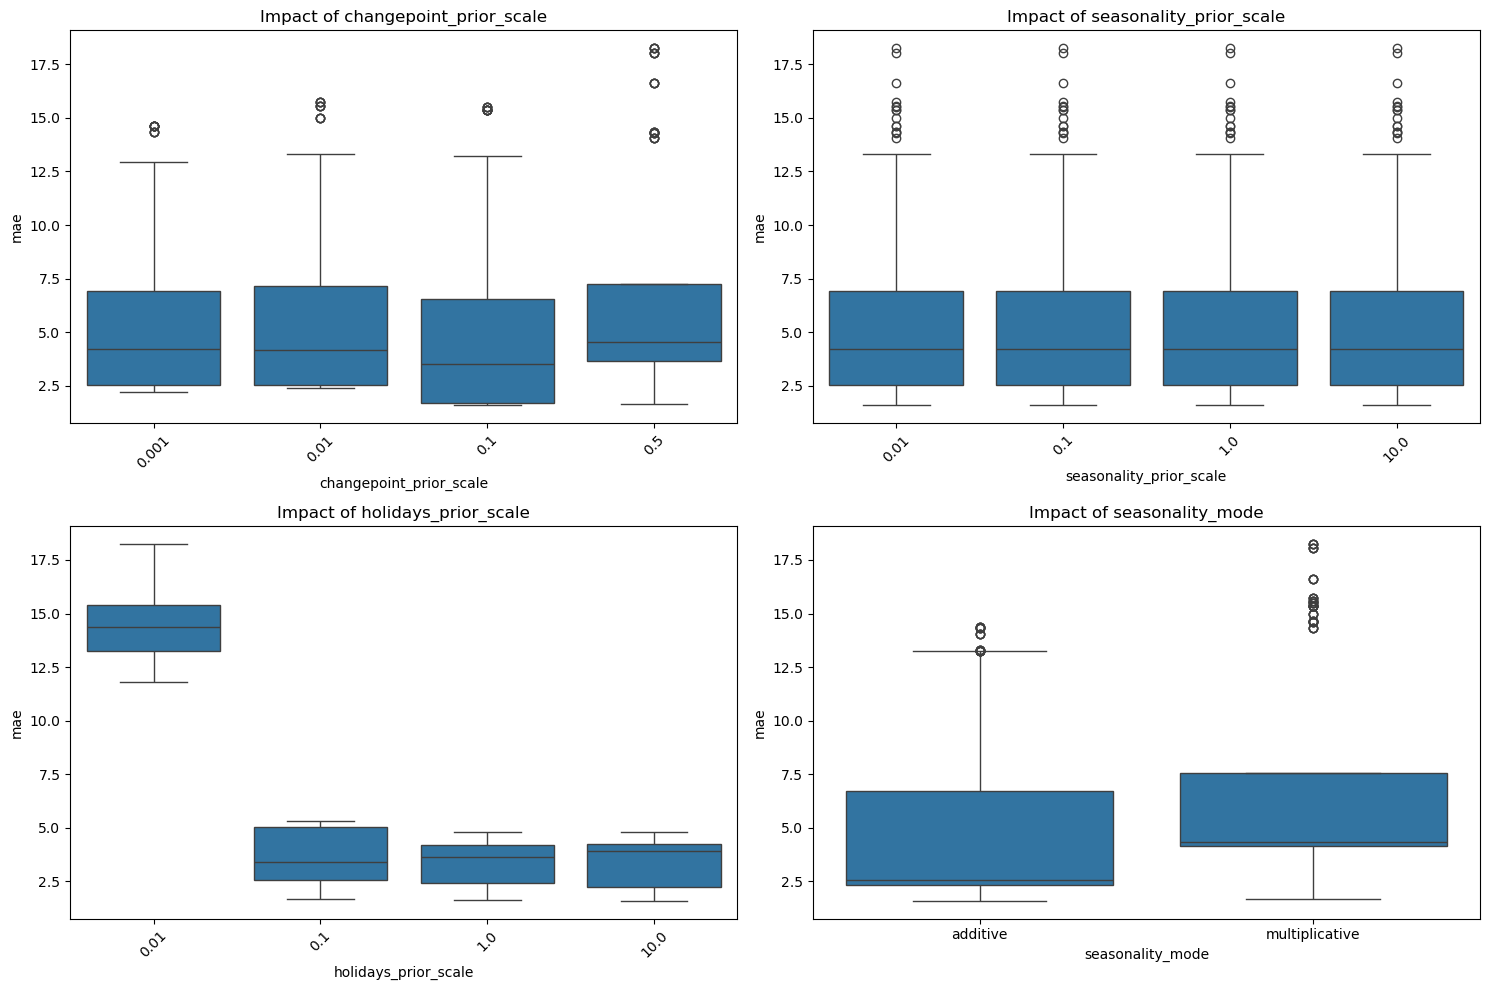

23:57:38 - cmdstanpy - INFO - Chain [1] start processing
23:57:39 - cmdstanpy - INFO - Chain [1] done processing



Final Model Performance:
MAE: 1.59
RMSE: 2.55


In [ ]:
import itertools
from prophet import Prophet
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def prophet_grid_search(df_train, df_test, parameter_grid):
    """
    Perform grid search for Prophet hyperparameters
    """
    # Generate all combinations of parameters
    all_params = [dict(zip(parameter_grid.keys(), v)) for v in itertools.product(*parameter_grid.values())]
    results = []
    
    # Progress tracking
    total_combinations = len(all_params)
    print(f"Testing {total_combinations} combinations of parameters")
    
    for params in all_params:
        # Initialize and fit model with current parameters
        model = Prophet(**params)
        
        # Add regressors
        regressors = ['Inventory', 'GMV', 'Page Views', 'EBC Page Views', 'Ad Spend', 'Ad Sales']
        for regressor in regressors:
            model.add_regressor(regressor)
            
        model.fit(df_train)
        
        # Make predictions on test set
        future = model.make_future_dataframe(periods=len(df_test), freq='W')
        for regressor in regressors:
            future[regressor] = pd.concat([df_train[regressor], df_test[regressor]]).reset_index(drop=True)
            
        forecast = model.predict(future)
        
        # Calculate metrics
        y_true = df_test['y'].values
        y_pred = forecast.tail(len(df_test))['yhat'].values
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # Store results
        params_dict = params.copy()
        params_dict['mae'] = mae
        params_dict['rmse'] = rmse
        results.append(params_dict)
        
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, Parameters: {params}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Define parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 0.95]
}

# Perform grid search
results_df = prophet_grid_search(train_df, test_df, param_grid)

results_df


Best parameters:
MAE: 1.59
RMSE: 2.55

Parameter values:
changepoint_prior_scale: 0.1
seasonality_prior_scale: 0.01
holidays_prior_scale: 10.0
seasonality_mode: additive
changepoint_range: 0.9


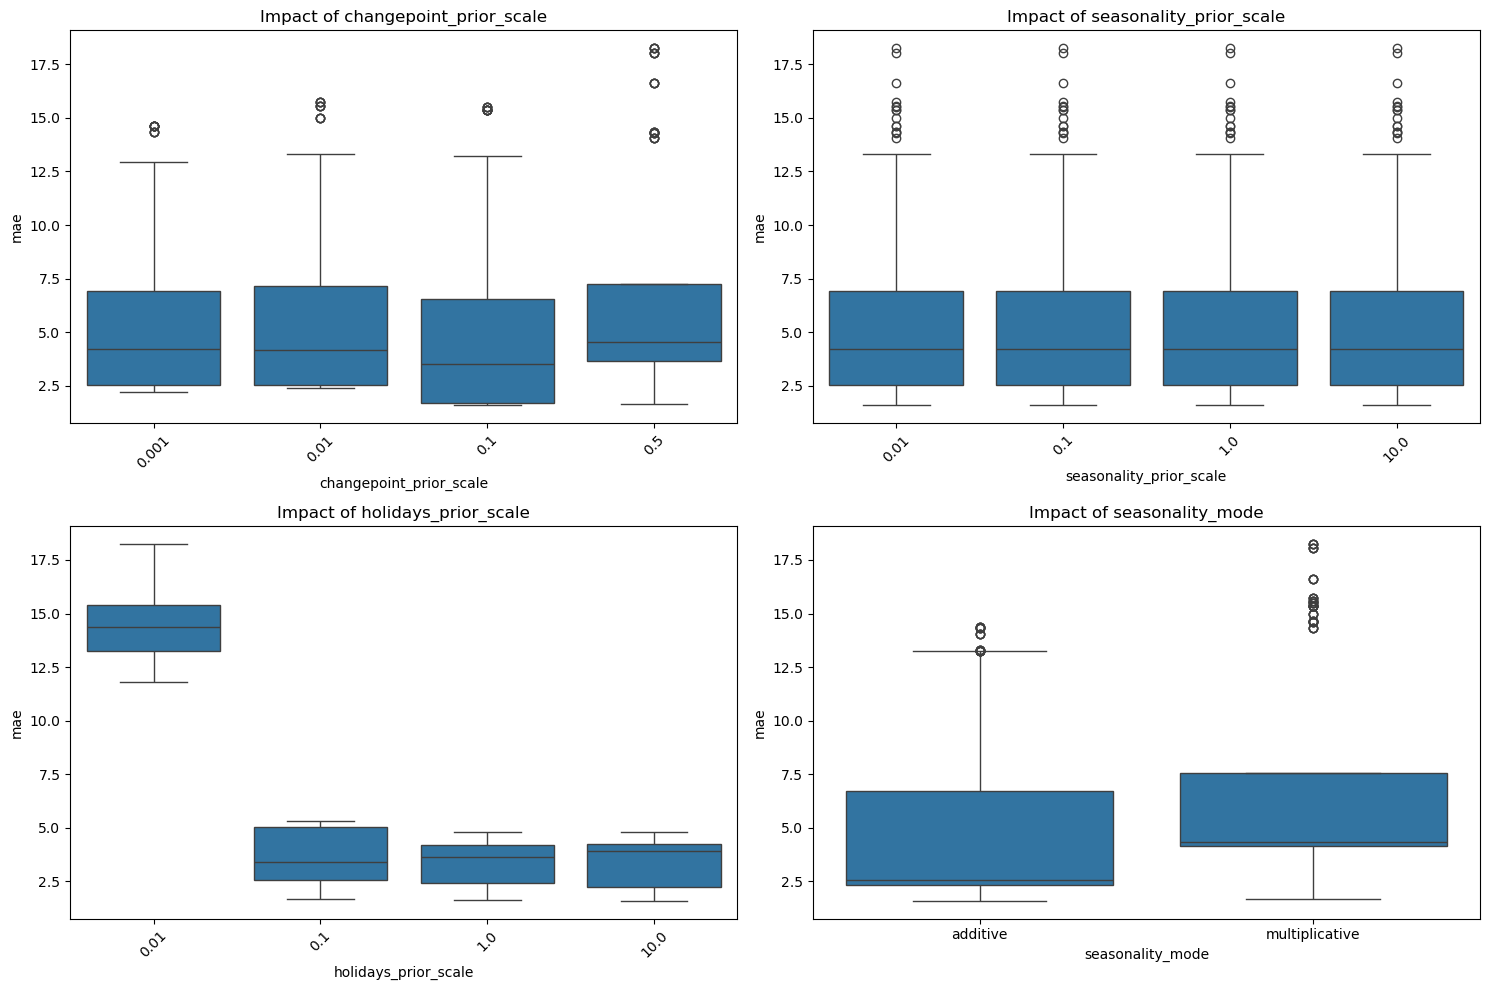

In [57]:
# Find best parameters
best_params = results_df.loc[results_df['mae'].idxmin()]
print("\nBest parameters:")
print(f"MAE: {best_params['mae']:.2f}")
print(f"RMSE: {best_params['rmse']:.2f}")
print("\nParameter values:")
for param in param_grid.keys():
    print(f"{param}: {best_params[param]}")

# Create visualization of parameter impact
plt.figure(figsize=(15, 10))

# Plot impact of changepoint_prior_scale
plt.subplot(2, 2, 1)
sns.boxplot(x='changepoint_prior_scale', y='mae', data=results_df)
plt.title('Impact of changepoint_prior_scale')
plt.xticks(rotation=45)

# Plot impact of seasonality_prior_scale
plt.subplot(2, 2, 2)
sns.boxplot(x='seasonality_prior_scale', y='mae', data=results_df)
plt.title('Impact of seasonality_prior_scale')
plt.xticks(rotation=45)

# Plot impact of holidays_prior_scale
plt.subplot(2, 2, 3)
sns.boxplot(x='holidays_prior_scale', y='mae', data=results_df)
plt.title('Impact of holidays_prior_scale')
plt.xticks(rotation=45)

# Plot impact of seasonality_mode
plt.subplot(2, 2, 4)
sns.boxplot(x='seasonality_mode', y='mae', data=results_df)
plt.title('Impact of seasonality_mode')

plt.tight_layout()
plt.show()

In [55]:
# Train final model with best parameters
best_model = Prophet(**{k: best_params[k] for k in param_grid.keys()})

# Add regressors to final model
regressors = ['Inventory', 'GMV', 'Page Views', 'EBC Page Views', 'Ad Spend', 'Ad Sales']
for regressor in regressors:
    best_model.add_regressor(regressor)

# Fit the model
best_model.fit(train_df)

# Make predictions
future = best_model.make_future_dataframe(periods=len(test_df), freq='W')
for regressor in regressors:
    future[regressor] = pd.concat([train_df[regressor], test_df[regressor]]).reset_index(drop=True)
    
final_forecast = best_model.predict(future)

# Calculate final metrics
final_mae = mean_absolute_error(test_df['y'].values, final_forecast.tail(len(test_df))['yhat'].values)
final_rmse = np.sqrt(mean_squared_error(test_df['y'].values, final_forecast.tail(len(test_df))['yhat'].values))

23:59:16 - cmdstanpy - INFO - Chain [1] start processing
23:59:16 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
print("\nFinal Model Performance:")
print(f"MAE: {final_mae:.2f}")
print(f"RMSE: {final_rmse:.2f}")


Final Model Performance:
MAE: 1.59
RMSE: 2.55


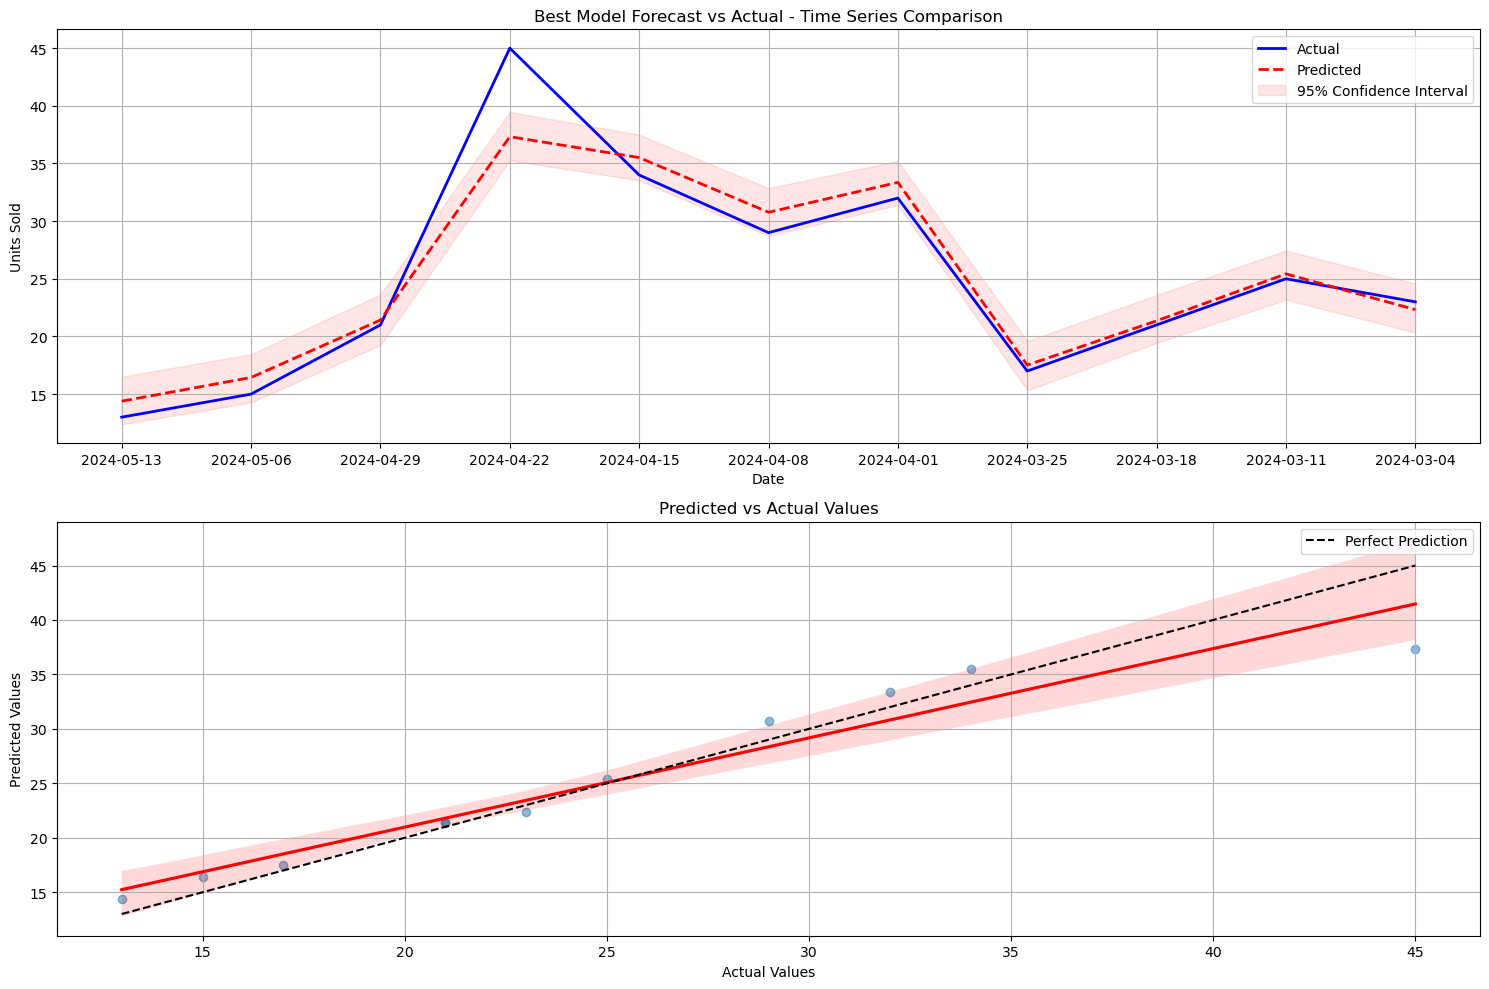

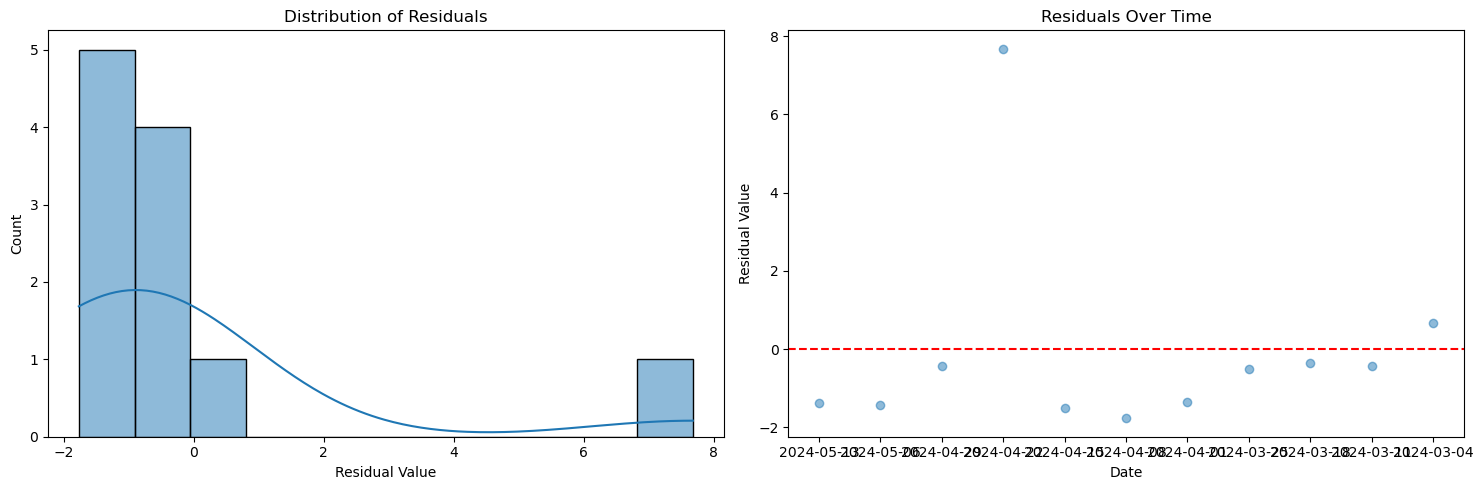


Forecast Summary Statistics:
Mean Absolute Percentage Error (MAPE): 5.77%
Prediction Interval Coverage: 90.91%
Average Weekly Accuracy: 94.23%


,Date,Actual,Predicted,Lower Bound,Upper Bound
40,2024-05-13,13,14.388004,12.372188,16.513022
41,2024-05-06,15,16.442168,14.278318,18.457537
42,2024-04-29,21,21.420807,19.257532,23.636713
43,2024-04-22,45,37.322749,35.268238,39.463983
44,2024-04-15,34,35.508863,33.537349,37.502592
45,2024-04-08,29,30.768391,28.712880,32.861474
46,2024-04-01,32,33.358834,31.406240,35.217105
47,2024-03-25,17,17.520830,15.321951,19.598794
48,2024-03-18,21,21.354553,19.438348,23.593866
49,2024-03-11,25,25.423243,23.187539,27.449053


In [59]:
# Create comparison plots for the best model's predictions
def plot_forecast_comparison(test_df, forecast, title="Forecast vs Actual"):
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Date': test_df['ds'],
        'Actual': test_df['y'],
        'Predicted': forecast['yhat'].tail(len(test_df)),
        'Lower Bound': forecast['yhat_lower'].tail(len(test_df)),
        'Upper Bound': forecast['yhat_upper'].tail(len(test_df))
    })
    
    # Create the visualization
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Time series comparison
    plt.subplot(2, 1, 1)
    plt.plot(comparison_df['Date'], comparison_df['Actual'], 'b-', label='Actual', linewidth=2)
    plt.plot(comparison_df['Date'], comparison_df['Predicted'], 'r--', label='Predicted', linewidth=2)
    plt.fill_between(comparison_df['Date'], 
                     comparison_df['Lower Bound'],
                     comparison_df['Upper Bound'],
                     color='r', alpha=0.1, label='95% Confidence Interval')
    plt.title(f'{title} - Time Series Comparison')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Scatter plot with regression line
    plt.subplot(2, 1, 2)
    sns.regplot(x='Actual', y='Predicted', data=comparison_df, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
    plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()], 
             [comparison_df['Actual'].min(), comparison_df['Actual'].max()], 
             'k--', label='Perfect Prediction')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis plots
    plt.figure(figsize=(15, 5))
    
    # Plot 3: Residuals
    residuals = comparison_df['Actual'] - comparison_df['Predicted']
    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residual Value')
    plt.ylabel('Count')
    
    # Plot 4: Residuals over time
    plt.subplot(1, 2, 2)
    plt.scatter(comparison_df['Date'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual Value')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nForecast Summary Statistics:")
    print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs((comparison_df['Actual'] - comparison_df['Predicted']) / comparison_df['Actual'])) * 100:.2f}%")
    print(f"Prediction Interval Coverage: {np.mean((comparison_df['Actual'] >= comparison_df['Lower Bound']) & (comparison_df['Actual'] <= comparison_df['Upper Bound'])) * 100:.2f}%")
    
    # Calculate weekly accuracy
    weekly_accuracy = 1 - np.abs((comparison_df['Actual'] - comparison_df['Predicted']) / comparison_df['Actual'])
    print(f"Average Weekly Accuracy: {weekly_accuracy.mean() * 100:.2f}%")
    
    return comparison_df

# Create the comparison plots for the best model
comparison_df = plot_forecast_comparison(test_df, final_forecast, "Best Model Forecast vs Actual")

# Optional: Save the comparison results to CSV
# comparison_df.to_csv('forecast_comparison_results.csv', index=False)

comparison_df